Useful links:

https://medium.com/@imabhi1216/fine-tuning-a-vision-transformer-vit-model-with-a-custom-dataset-37840e4e9268#f0a3

https://www.kaggle.com/code/luthei/vit-vs-cnn-on-wikiart/notebook#3.2-Test-Accuracy



In [1]:
import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time

from datasets import load_dataset

from transformers import ViTModel
from transformers import ViTImageProcessor, Trainer, TrainingArguments
from transformers import EvalPrediction
import evaluate
from sklearn.metrics import top_k_accuracy_score
import torch.quantization
from collections import Counter
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Dataset
https://huggingface.co/datasets/huggan/wikiart

In [3]:
def plot_histogram(data, title):
    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=range(min(data), max(data) + 2), edgecolor='black')
    plt.title(title)
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    plt.show()

In [4]:
dataset = load_dataset("huggan/wikiart", split="train")

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/45 [00:00<?, ?it/s]

In [5]:
print(f"Total number of records: {len(dataset)}")
print(f"Number of columns: {len(dataset.column_names)}")
print(dataset.column_names)

Total number of records: 81444
Number of columns: 4
['image', 'artist', 'genre', 'style']


In [6]:
unique_genres = set(dataset.features['genre'].names)
print(f"Number of genres: {unique_genres.__len__()}")
print(f"Unique genres: {unique_genres}")

Number of genres: 11
Unique genres: {'Unknown Genre', 'cityscape', 'still_life', 'genre_painting', 'nude_painting', 'illustration', 'portrait', 'sketch_and_study', 'abstract_painting', 'religious_painting', 'landscape'}


In [7]:
unique_style = set(dataset.features['style'].names)
print(f"Number of styles: {unique_style.__len__()}")
print(f"Unique styles: {unique_style}")

Number of styles: 27
Unique styles: {'High_Renaissance', 'Symbolism', 'Romanticism', 'Ukiyo_e', 'Pop_Art', 'Expressionism', 'Minimalism', 'Post_Impressionism', 'Contemporary_Realism', 'Art_Nouveau', 'Mannerism_Late_Renaissance', 'Realism', 'Color_Field_Painting', 'Rococo', 'New_Realism', 'Abstract_Expressionism', 'Naive_Art_Primitivism', 'Northern_Renaissance', 'Cubism', 'Early_Renaissance', 'Baroque', 'Impressionism', 'Pointillism', 'Synthetic_Cubism', 'Fauvism', 'Action_painting', 'Analytical_Cubism'}


We will be using 3 columns: image, style and genre

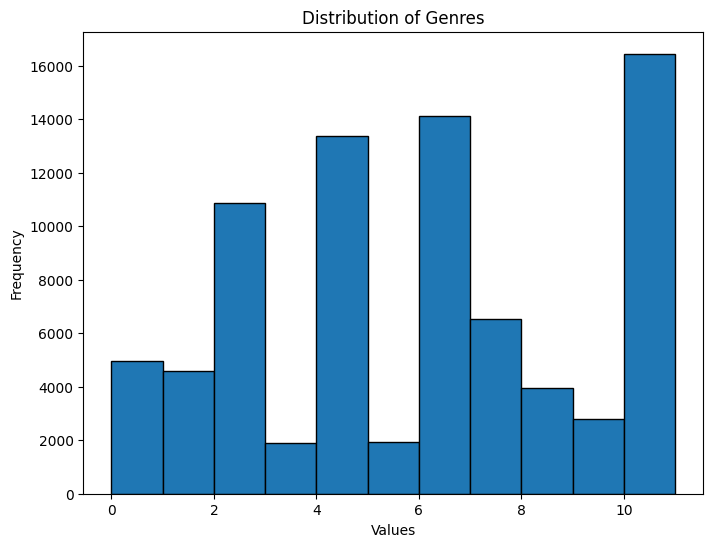

In [8]:
plot_histogram(dataset['genre'], "Distribution of Genres")

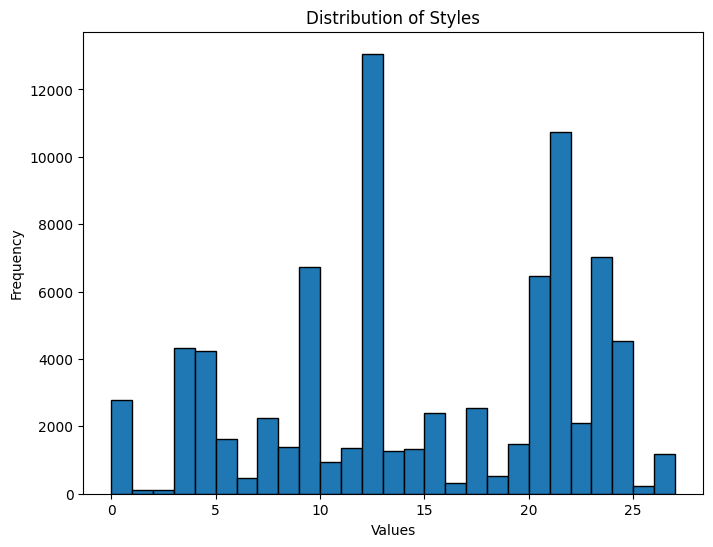

In [9]:
plot_histogram(dataset['style'], "Distribution of Styles")

Concerning disproportion  in distribution of genres. This may negatively impact the classification results. 

## ViT

### Class resampling

In [10]:
# Count samples per (genre, style)
counter = Counter(dataset['style'])
min_count = min(counter.values())

print(f"Minimum count of samples in any style: {min_count}")

# Group indices by (genre, style)
grouped_indices = {}
for idx, (s) in enumerate(dataset['style']):
    grouped_indices.setdefault(s, []).append(idx)

# Sample min_count indices from each group
selected_indices = []
for indices in grouped_indices.values():
    selected_indices.extend(random.sample(indices, min_count))

# Select balanced subset
dataset = dataset.select(selected_indices)
print(f"Balanced dataset size: {len(dataset)}")

Minimum count of samples in any style: 98
Balanced dataset size: 2646


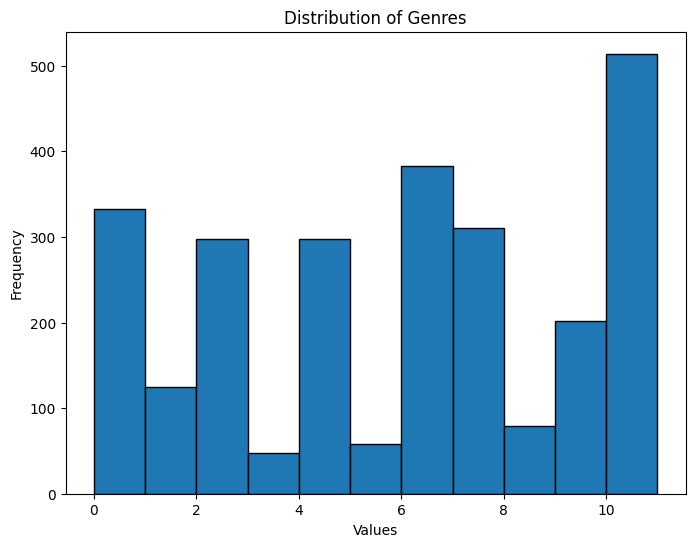

In [11]:
plot_histogram(dataset['genre'], "Distribution of Genres")

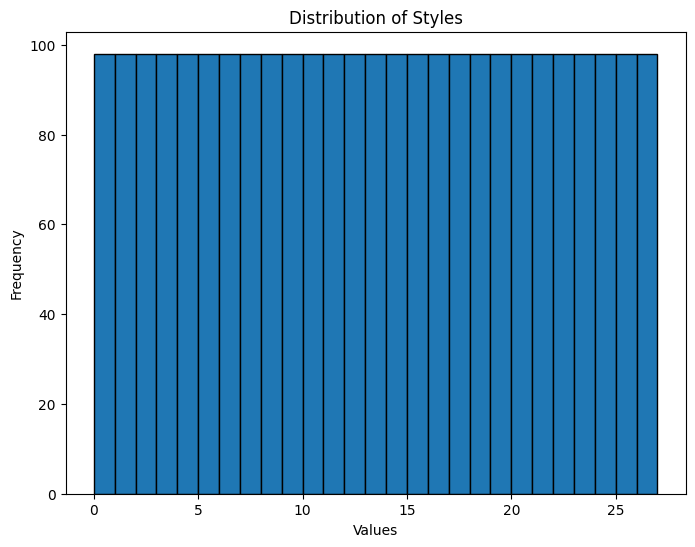

In [12]:
plot_histogram(dataset['style'], "Distribution of Styles")

### Encoding genre and style labels

In [13]:
genres = list(set(dataset['genre']))
styles = list(set(dataset['style']))

id2genre = {i: name for i, name in enumerate(dataset.features['genre'].names)}
id2style = {i: name for i, name in enumerate(dataset.features['style'].names)}

genre2id = {g: i for i, g in enumerate(genres)}
style2id = {s: i for i, s in enumerate(styles)}

def encode_labels(example):
    example['genre_label'] = id2genre[example['genre']]
    example['style_label'] = id2style[example['style']]
    return example

dataset = dataset.map(encode_labels)

Map:   0%|          | 0/2646 [00:00<?, ? examples/s]

### Data examples

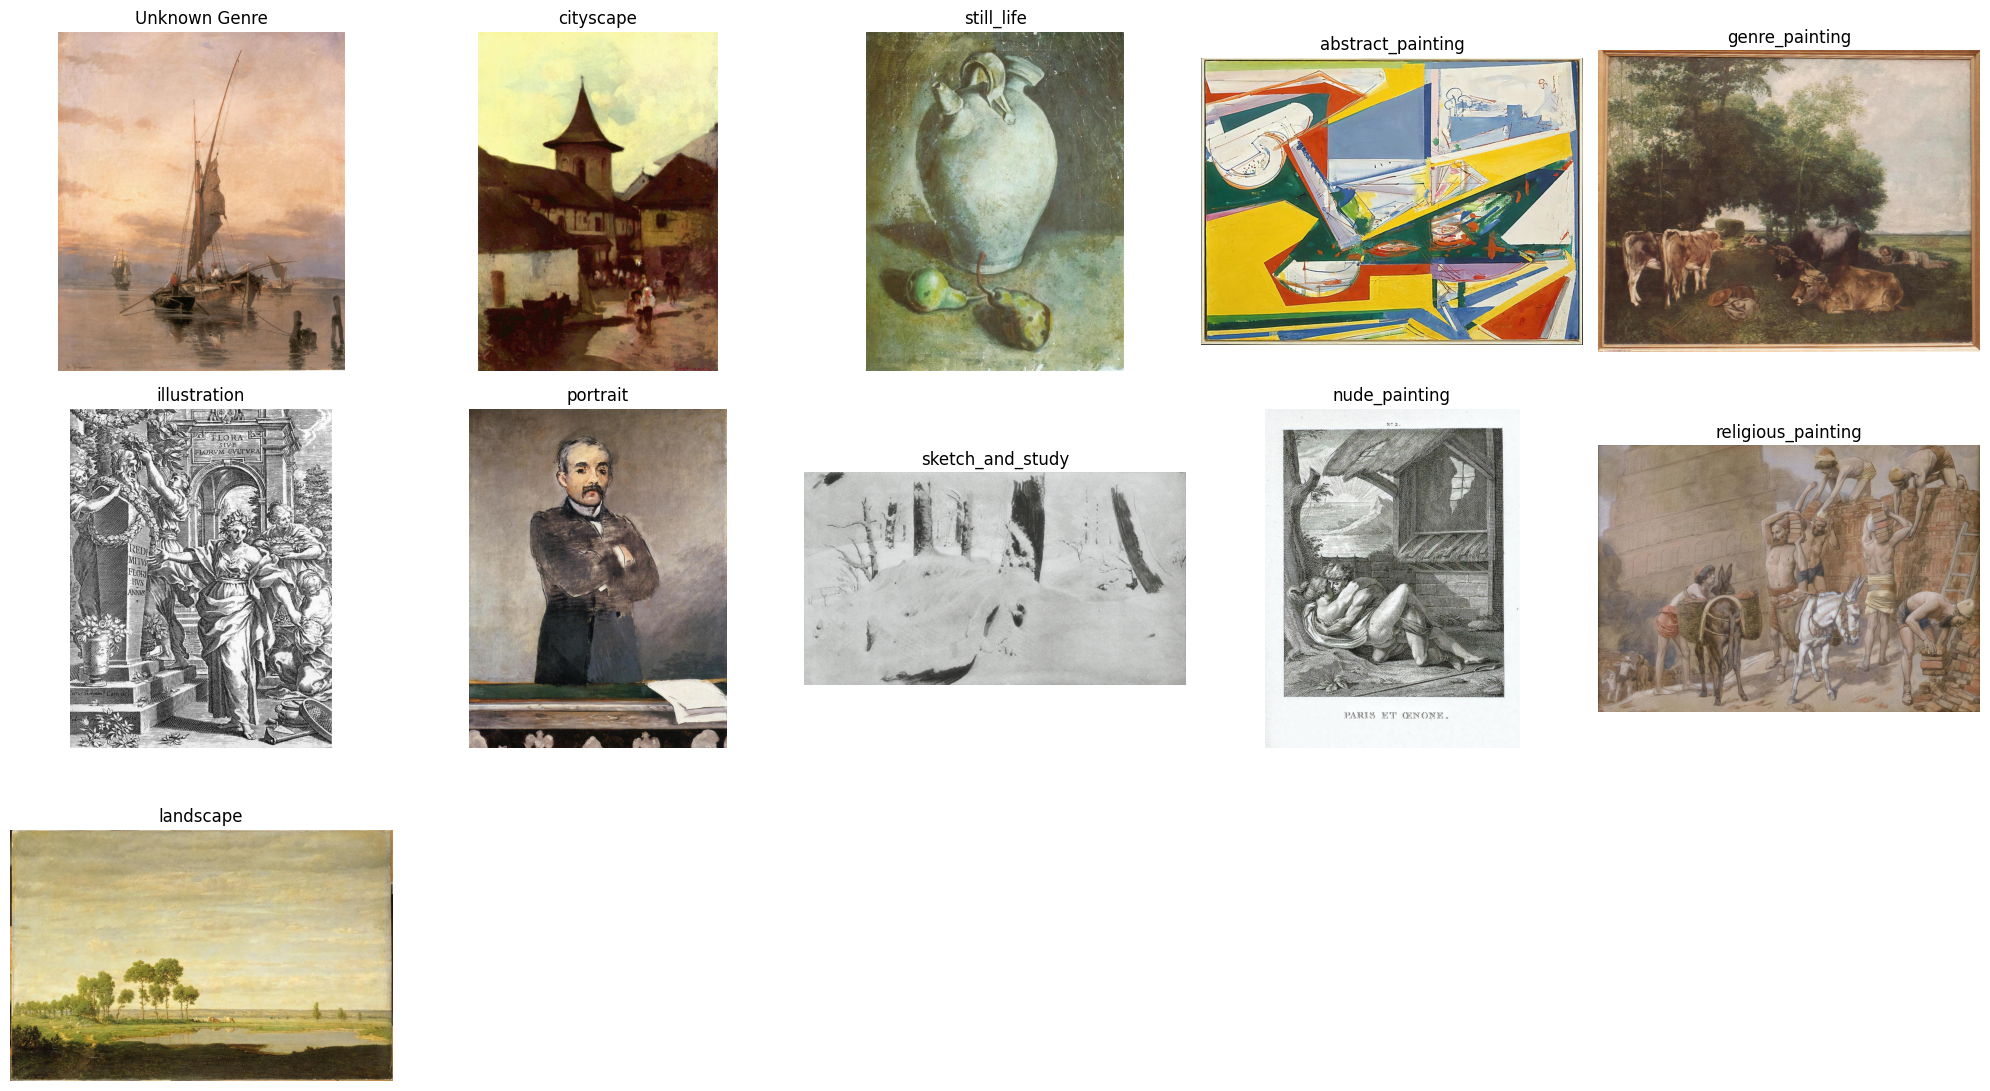

In [14]:
unique_genres = set(dataset['genre_label'])
list_of_images_g = []
for genre in unique_genres:
    for i in range(len(dataset)):
        if dataset[i]['genre_label'] == genre:
            list_of_images_g.append(dataset[i]['image'])
            break

plt.figure(figsize=(20, 20))
for i in range(len(list_of_images_g)):
    plt.subplot(5, 5, i + 1)
    plt.imshow(list_of_images_g[i])
    plt.title(f"{list(unique_genres)[i]}")
    plt.axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


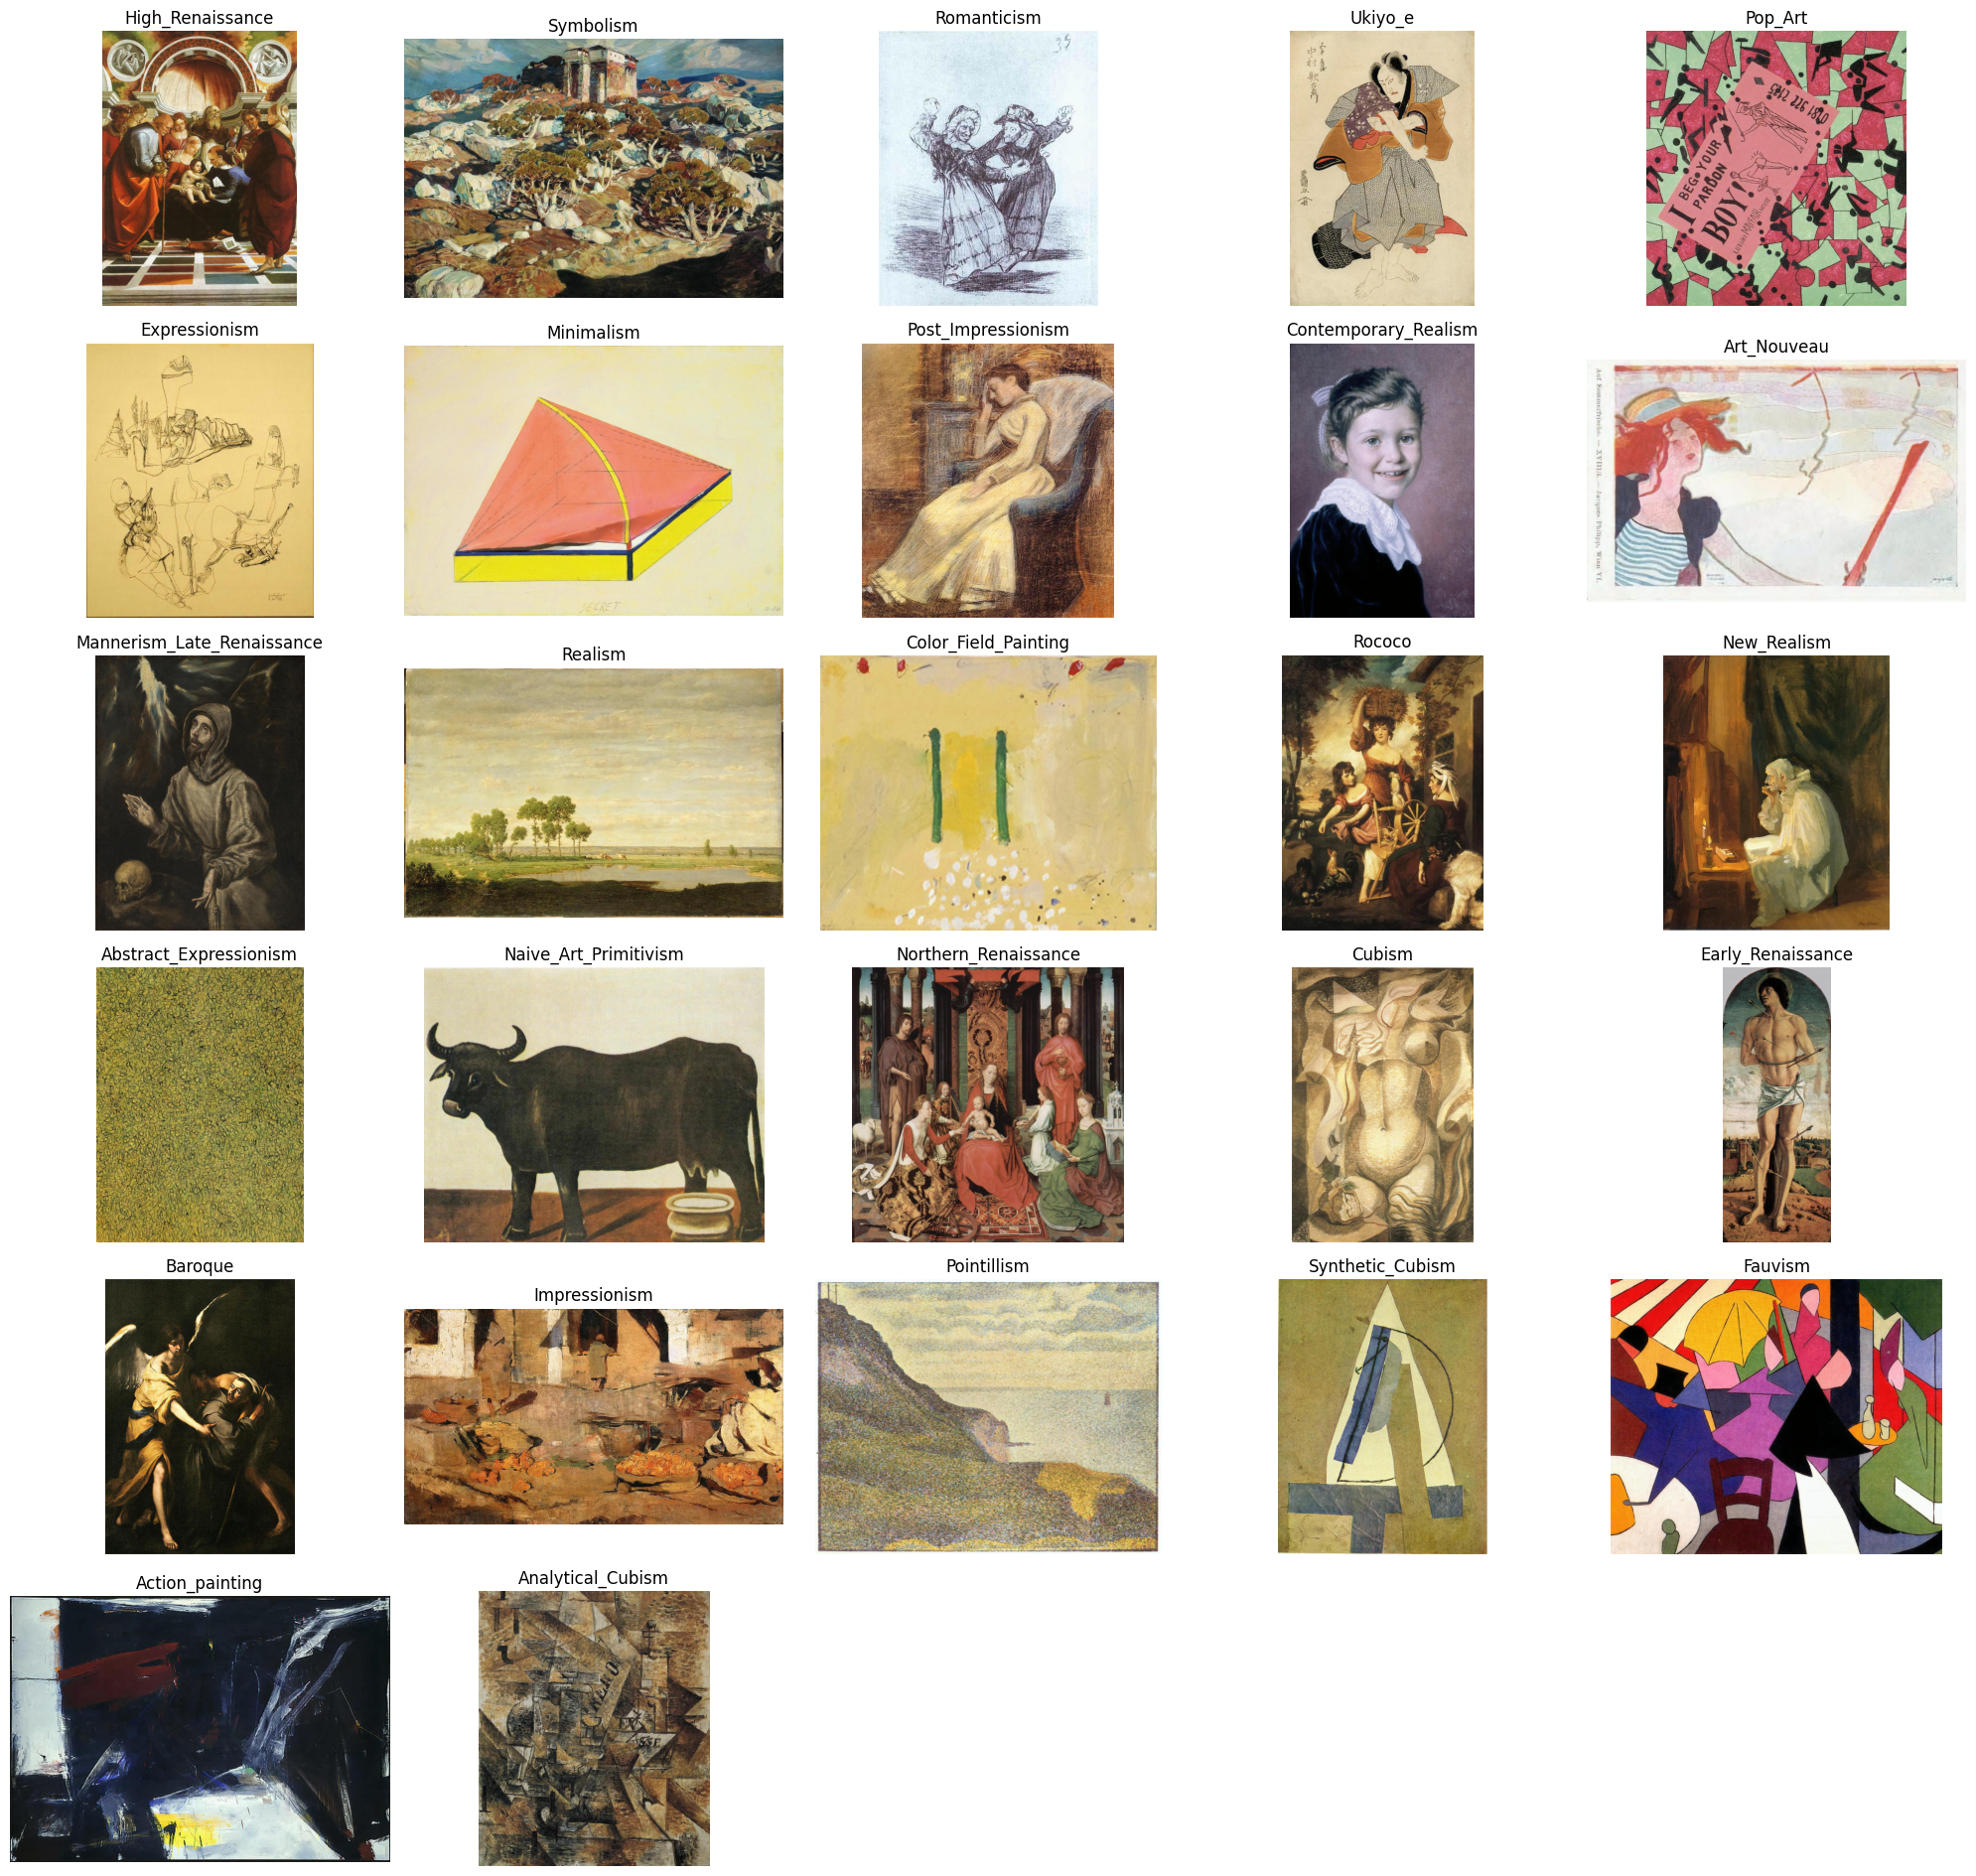

In [15]:
unique_styles = list(set(dataset['style_label']))
list_of_images_s = []
for style in unique_styles:
    for i in range(len(dataset)):
        if dataset[i]['style_label'] == style:
            list_of_images_s.append(dataset[i]['image'])
            break

plt.figure(figsize=(20, 20))
for i in range(len(list_of_images_s)):
    plt.subplot(6, 5, i + 1)
    plt.imshow(list_of_images_s[i])
    plt.title(f"{unique_styles[i]}")
    plt.axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Preprocessing images

In [16]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

def preprocess(example):
    inputs = processor(images=example['image'], return_tensors="pt")
    example['pixel_values'] = inputs['pixel_values'][0]
    return example

dataset = dataset.map(preprocess)

Map:   0%|          | 0/2646 [00:00<?, ? examples/s]

#### Splitting dataset into train and test sets

In [17]:
def collate_fn(examples):
    pixel_values = torch.stack([
        torch.tensor(example["pixel_values"]) if not isinstance(example["pixel_values"], torch.Tensor)
        else example["pixel_values"]
        for example in examples
    ])
    genre_labels = torch.tensor([example["genre"] for example in examples])
    style_labels = torch.tensor([example["style"] for example in examples])
    return {
        "pixel_values": pixel_values,
        "genre_labels": genre_labels,
        "style_labels": style_labels
    }

In [18]:
split = dataset.train_test_split(test_size=0.2)
train_dataset = split['train']
eval_dataset = split['test']

### Model

In [19]:
class ViTMultiTask(nn.Module):
    def __init__(self, num_genres, num_styles):
        super().__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
        hidden_size = self.vit.config.hidden_size
        self.genre_head = nn.Linear(hidden_size, num_genres)
        self.style_head = nn.Linear(hidden_size, num_styles)

    def forward(self, pixel_values, **kwargs):
        outputs = self.vit(pixel_values=pixel_values)
        pooled = outputs.pooler_output
        genre_logits = self.genre_head(pooled)
        style_logits = self.style_head(pooled)
        return genre_logits, style_logits

In [20]:
# Initialize the ViT model with your genre classes
model = ViTMultiTask(num_genres=len(genres), num_styles=len(styles))
model.to(device)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTMultiTask(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn):

In [21]:
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')
def compute_metrics(eval_pred: EvalPrediction):
    # Extract and convert to numpy if needed
    genre_logits, style_logits = eval_pred.predictions
    if isinstance(genre_logits, torch.Tensor):
        genre_logits = genre_logits.cpu().numpy()
        style_logits = style_logits.cpu().numpy()
    
    genre_labels = eval_pred.label_ids["genre_labels"]
    style_labels = eval_pred.label_ids["style_labels"]
    if isinstance(genre_labels, torch.Tensor):
        genre_labels = genre_labels.cpu().numpy()
        style_labels = style_labels.cpu().numpy()
    
    genre_preds = np.argmax(genre_logits, axis=1)
    style_preds = np.argmax(style_logits, axis=1)
    genre_acc = (genre_preds == genre_labels).mean()
    style_acc = (style_preds == style_labels).mean()
    avg_acc = (genre_acc + style_acc) / 2
    return {
        "eval_genre_accuracy": genre_acc,
        "eval_style_accuracy": style_acc,
        "eval_avg_accuracy": avg_acc
    }

In [22]:
class MultiTaskTrainer(Trainer):
    def __init__(self, *args, compute_metrics=None, **kwargs):
        super().__init__(*args, compute_metrics=compute_metrics, **kwargs)

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        pixel_values = inputs["pixel_values"].to(model.vit.device)
        genre_labels = inputs["genre_labels"].to(model.vit.device)
        style_labels = inputs["style_labels"].to(model.vit.device)
        genre_logits, style_logits = model(pixel_values)
        loss_fct = nn.CrossEntropyLoss()
        genre_loss = loss_fct(genre_logits, genre_labels)
        style_loss = loss_fct(style_logits, style_labels)
        loss = genre_loss + style_loss 
        if return_outputs:
            outputs = (genre_logits, style_logits)
            return loss, outputs
        return loss

    def prediction_step(self, model, inputs, prediction_loss_only=False, ignore_keys=None):
        # Move inputs to appropriate device
        for k, v in inputs.items():
            if isinstance(v, torch.Tensor):
                inputs[k] = v.to(model.vit.device)

        with torch.no_grad():
            # Forward pass
            genre_logits, style_logits = model(inputs["pixel_values"])

            # Get labels
            genre_labels = inputs["genre_labels"]
            style_labels = inputs["style_labels"]

            # Compute loss
            loss_fct = nn.CrossEntropyLoss()
            genre_loss = loss_fct(genre_logits, genre_labels)
            style_loss = loss_fct(style_logits, style_labels)
            loss = genre_loss + style_loss

        if prediction_loss_only:
            return (loss, None, None)

        return (
            loss.detach(),
            (genre_logits.detach(), style_logits.detach()),
            {"genre_labels": genre_labels.detach(),
             "style_labels": style_labels.detach()}
        )

In [113]:
train_args = TrainingArguments(
    output_dir="output-models",
    per_device_train_batch_size=16,
    num_train_epochs=2,
    fp16=True,
    save_steps=10,
    eval_steps=10,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
    eval_strategy='steps',
    metric_for_best_model='eval_avg_accuracy',
)

In [116]:
trainer = MultiTaskTrainer(
    model=model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

In [121]:
from sklearn.model_selection import ParameterGrid
import copy
import json
from datetime import datetime

# Define hyperparameter grid
param_grid = {
    'learning_rate': [2e-4, 5e-4],
    'batch_size': [8, 16, 32],
    'num_epochs': [1, 2],
    'weight_decay': [0.01, 0.1]
}

# Generate all combinations of hyperparameters
grid = list(ParameterGrid(param_grid))
print(f"Total number of combinations to try: {len(grid)}")

# Create a directory to store results
import os
os.makedirs("grid_search_results", exist_ok=True)

# Function to train and evaluate a model with given hyperparameters
def train_and_evaluate(params, train_dataset, eval_dataset):
    # Create a fresh model for each run
    model = ViTMultiTask(num_genres=len(genres), num_styles=len(styles))
    model.to(device)

    # Set up training arguments based on the parameters
    train_args = TrainingArguments(
        output_dir=f"output-models/run-{datetime.now().strftime('%Y%m%d-%H%M%S')}",
        per_device_train_batch_size=params['batch_size'],
        num_train_epochs=params['num_epochs'],
        fp16=True,
        save_steps=50,
        eval_steps=50,
        logging_steps=50,
        learning_rate=params['learning_rate'],
        weight_decay=params['weight_decay'],
        save_total_limit=1,
        remove_unused_columns=False,
        push_to_hub=False,
        report_to='tensorboard',
        load_best_model_at_end=True,
        eval_strategy='steps',
        metric_for_best_model='eval_avg_accuracy',
    )

    # Initialize trainer
    trainer = MultiTaskTrainer(
        model=model,
        args=train_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_results = trainer.evaluate()

    return {
        'params': params,
        'eval_results': eval_results
    }


Total number of combinations to try: 24


In [122]:
results = []

for i, params in enumerate(grid):
    print(f"Training combination {i+1}/{len(grid)}: {params}")
    try:
        result = train_and_evaluate(params, train_dataset, eval_dataset)
        results.append(result)

        # Save intermediate results
        with open(f"grid_search_results/result_{i}.json", 'w') as f:
            # Convert any non-serializable objects to strings
            serializable_result = copy.deepcopy(result)
            serializable_result['eval_results'] = {k: float(v) if isinstance(v, (int, float)) else str(v)
                                                for k, v in result['eval_results'].items()}
            json.dump(serializable_result, f, indent=2)

        print(f"Completed combination {i+1}. Metrics: {result['eval_results']}")
    except Exception as e:
        print(f"Error with combination {i+1}: {e}")


Training combination 1/24: {'batch_size': 8, 'learning_rate': 0.0002, 'num_epochs': 1, 'weight_decay': 0.01}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed combination 1. Metrics: {'eval_genre_accuracy': 0.6037735849056604, 'eval_style_accuracy': 0.35094339622641507, 'eval_avg_accuracy': 0.47735849056603774, 'eval_loss': 3.139211416244507, 'eval_runtime': 69.0677, 'eval_samples_per_second': 7.674, 'eval_steps_per_second': 0.97, 'epoch': 1.0}
Training combination 2/24: {'batch_size': 8, 'learning_rate': 0.0002, 'num_epochs': 1, 'weight_decay': 0.1}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed combination 2. Metrics: {'eval_genre_accuracy': 0.6075471698113207, 'eval_style_accuracy': 0.3622641509433962, 'eval_avg_accuracy': 0.4849056603773585, 'eval_loss': 3.090956211090088, 'eval_runtime': 66.5063, 'eval_samples_per_second': 7.969, 'eval_steps_per_second': 1.007, 'epoch': 1.0}
Training combination 3/24: {'batch_size': 8, 'learning_rate': 0.0002, 'num_epochs': 2, 'weight_decay': 0.01}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed combination 3. Metrics: {'eval_genre_accuracy': 0.6471698113207547, 'eval_style_accuracy': 0.4509433962264151, 'eval_avg_accuracy': 0.5490566037735849, 'eval_loss': 2.7677931785583496, 'eval_runtime': 62.5006, 'eval_samples_per_second': 8.48, 'eval_steps_per_second': 1.072, 'epoch': 2.0}
Training combination 4/24: {'batch_size': 8, 'learning_rate': 0.0002, 'num_epochs': 2, 'weight_decay': 0.1}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed combination 4. Metrics: {'eval_genre_accuracy': 0.6396226415094339, 'eval_style_accuracy': 0.4339622641509434, 'eval_avg_accuracy': 0.5367924528301886, 'eval_loss': 2.8327932357788086, 'eval_runtime': 59.8682, 'eval_samples_per_second': 8.853, 'eval_steps_per_second': 1.119, 'epoch': 2.0}
Training combination 5/24: {'batch_size': 8, 'learning_rate': 0.0005, 'num_epochs': 1, 'weight_decay': 0.01}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed combination 5. Metrics: {'eval_genre_accuracy': 0.38113207547169814, 'eval_style_accuracy': 0.1660377358490566, 'eval_avg_accuracy': 0.27358490566037735, 'eval_loss': 4.702942848205566, 'eval_runtime': 54.4206, 'eval_samples_per_second': 9.739, 'eval_steps_per_second': 1.231, 'epoch': 1.0}
Training combination 6/24: {'batch_size': 8, 'learning_rate': 0.0005, 'num_epochs': 1, 'weight_decay': 0.1}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed combination 6. Metrics: {'eval_genre_accuracy': 0.4830188679245283, 'eval_style_accuracy': 0.22830188679245284, 'eval_avg_accuracy': 0.35566037735849054, 'eval_loss': 3.9227805137634277, 'eval_runtime': 54.0347, 'eval_samples_per_second': 9.809, 'eval_steps_per_second': 1.24, 'epoch': 1.0}
Training combination 7/24: {'batch_size': 8, 'learning_rate': 0.0005, 'num_epochs': 2, 'weight_decay': 0.01}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed combination 7. Metrics: {'eval_genre_accuracy': 0.5207547169811321, 'eval_style_accuracy': 0.33773584905660375, 'eval_avg_accuracy': 0.4292452830188679, 'eval_loss': 3.437230110168457, 'eval_runtime': 60.8709, 'eval_samples_per_second': 8.707, 'eval_steps_per_second': 1.101, 'epoch': 2.0}
Training combination 8/24: {'batch_size': 8, 'learning_rate': 0.0005, 'num_epochs': 2, 'weight_decay': 0.1}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed combination 8. Metrics: {'eval_genre_accuracy': 0.35660377358490564, 'eval_style_accuracy': 0.11320754716981132, 'eval_avg_accuracy': 0.2349056603773585, 'eval_loss': 4.698146820068359, 'eval_runtime': 62.5155, 'eval_samples_per_second': 8.478, 'eval_steps_per_second': 1.072, 'epoch': 2.0}
Training combination 9/24: {'batch_size': 16, 'learning_rate': 0.0002, 'num_epochs': 1, 'weight_decay': 0.01}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed combination 9. Metrics: {'eval_genre_accuracy': 0.5528301886792453, 'eval_style_accuracy': 0.3113207547169811, 'eval_avg_accuracy': 0.4320754716981132, 'eval_loss': 3.4380571842193604, 'eval_runtime': 63.4453, 'eval_samples_per_second': 8.354, 'eval_steps_per_second': 1.056, 'epoch': 1.0}
Training combination 10/24: {'batch_size': 16, 'learning_rate': 0.0002, 'num_epochs': 1, 'weight_decay': 0.1}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed combination 10. Metrics: {'eval_genre_accuracy': 0.6, 'eval_style_accuracy': 0.3433962264150943, 'eval_avg_accuracy': 0.4716981132075472, 'eval_loss': 3.3099780082702637, 'eval_runtime': 61.8013, 'eval_samples_per_second': 8.576, 'eval_steps_per_second': 1.084, 'epoch': 1.0}
Training combination 11/24: {'batch_size': 16, 'learning_rate': 0.0002, 'num_epochs': 2, 'weight_decay': 0.01}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed combination 11. Metrics: {'eval_genre_accuracy': 0.6433962264150943, 'eval_style_accuracy': 0.4528301886792453, 'eval_avg_accuracy': 0.5481132075471697, 'eval_loss': 2.7785205841064453, 'eval_runtime': 61.3689, 'eval_samples_per_second': 8.636, 'eval_steps_per_second': 1.092, 'epoch': 2.0}
Training combination 12/24: {'batch_size': 16, 'learning_rate': 0.0002, 'num_epochs': 2, 'weight_decay': 0.1}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed combination 12. Metrics: {'eval_genre_accuracy': 0.6188679245283019, 'eval_style_accuracy': 0.44528301886792454, 'eval_avg_accuracy': 0.5320754716981132, 'eval_loss': 2.807138681411743, 'eval_runtime': 66.1242, 'eval_samples_per_second': 8.015, 'eval_steps_per_second': 1.013, 'epoch': 2.0}
Training combination 13/24: {'batch_size': 16, 'learning_rate': 0.0005, 'num_epochs': 1, 'weight_decay': 0.01}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed combination 13. Metrics: {'eval_genre_accuracy': 0.5320754716981132, 'eval_style_accuracy': 0.2811320754716981, 'eval_avg_accuracy': 0.4066037735849056, 'eval_loss': 3.5637354850769043, 'eval_runtime': 71.4014, 'eval_samples_per_second': 7.423, 'eval_steps_per_second': 0.938, 'epoch': 1.0}
Training combination 14/24: {'batch_size': 16, 'learning_rate': 0.0005, 'num_epochs': 1, 'weight_decay': 0.1}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed combination 14. Metrics: {'eval_genre_accuracy': 0.5415094339622641, 'eval_style_accuracy': 0.32264150943396225, 'eval_avg_accuracy': 0.4320754716981132, 'eval_loss': 3.492260694503784, 'eval_runtime': 67.2064, 'eval_samples_per_second': 7.886, 'eval_steps_per_second': 0.997, 'epoch': 1.0}
Training combination 15/24: {'batch_size': 16, 'learning_rate': 0.0005, 'num_epochs': 2, 'weight_decay': 0.01}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed combination 15. Metrics: {'eval_genre_accuracy': 0.6018867924528302, 'eval_style_accuracy': 0.4056603773584906, 'eval_avg_accuracy': 0.5037735849056604, 'eval_loss': 2.9787003993988037, 'eval_runtime': 67.5646, 'eval_samples_per_second': 7.844, 'eval_steps_per_second': 0.992, 'epoch': 2.0}
Training combination 16/24: {'batch_size': 16, 'learning_rate': 0.0005, 'num_epochs': 2, 'weight_decay': 0.1}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed combination 16. Metrics: {'eval_genre_accuracy': 0.5773584905660377, 'eval_style_accuracy': 0.4169811320754717, 'eval_avg_accuracy': 0.4971698113207547, 'eval_loss': 3.012367010116577, 'eval_runtime': 57.3324, 'eval_samples_per_second': 9.244, 'eval_steps_per_second': 1.169, 'epoch': 2.0}
Training combination 17/24: {'batch_size': 32, 'learning_rate': 0.0002, 'num_epochs': 1, 'weight_decay': 0.01}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed combination 17. Metrics: {'eval_genre_accuracy': 0.5584905660377358, 'eval_style_accuracy': 0.3018867924528302, 'eval_avg_accuracy': 0.43018867924528303, 'eval_loss': 3.6708288192749023, 'eval_runtime': 75.3427, 'eval_samples_per_second': 7.035, 'eval_steps_per_second': 0.889, 'epoch': 1.0}
Training combination 18/24: {'batch_size': 32, 'learning_rate': 0.0002, 'num_epochs': 1, 'weight_decay': 0.1}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed combination 18. Metrics: {'eval_genre_accuracy': 0.530188679245283, 'eval_style_accuracy': 0.2811320754716981, 'eval_avg_accuracy': 0.4056603773584906, 'eval_loss': 3.680230140686035, 'eval_runtime': 62.3347, 'eval_samples_per_second': 8.502, 'eval_steps_per_second': 1.075, 'epoch': 1.0}
Training combination 19/24: {'batch_size': 32, 'learning_rate': 0.0002, 'num_epochs': 2, 'weight_decay': 0.01}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed combination 19. Metrics: {'eval_genre_accuracy': 0.6358490566037736, 'eval_style_accuracy': 0.39245283018867927, 'eval_avg_accuracy': 0.5141509433962264, 'eval_loss': 3.004894733428955, 'eval_runtime': 60.9841, 'eval_samples_per_second': 8.691, 'eval_steps_per_second': 1.099, 'epoch': 2.0}
Training combination 20/24: {'batch_size': 32, 'learning_rate': 0.0002, 'num_epochs': 2, 'weight_decay': 0.1}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed combination 20. Metrics: {'eval_genre_accuracy': 0.6377358490566037, 'eval_style_accuracy': 0.41320754716981134, 'eval_avg_accuracy': 0.5254716981132075, 'eval_loss': 2.991727828979492, 'eval_runtime': 55.946, 'eval_samples_per_second': 9.473, 'eval_steps_per_second': 1.198, 'epoch': 2.0}
Training combination 21/24: {'batch_size': 32, 'learning_rate': 0.0005, 'num_epochs': 1, 'weight_decay': 0.01}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed combination 21. Metrics: {'eval_genre_accuracy': 0.5509433962264151, 'eval_style_accuracy': 0.3264150943396226, 'eval_avg_accuracy': 0.4386792452830188, 'eval_loss': 3.4483773708343506, 'eval_runtime': 58.4722, 'eval_samples_per_second': 9.064, 'eval_steps_per_second': 1.146, 'epoch': 1.0}
Training combination 22/24: {'batch_size': 32, 'learning_rate': 0.0005, 'num_epochs': 1, 'weight_decay': 0.1}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed combination 22. Metrics: {'eval_genre_accuracy': 0.5490566037735849, 'eval_style_accuracy': 0.3320754716981132, 'eval_avg_accuracy': 0.440566037735849, 'eval_loss': 3.3973066806793213, 'eval_runtime': 56.8077, 'eval_samples_per_second': 9.33, 'eval_steps_per_second': 1.179, 'epoch': 1.0}
Training combination 23/24: {'batch_size': 32, 'learning_rate': 0.0005, 'num_epochs': 2, 'weight_decay': 0.01}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed combination 23. Metrics: {'eval_genre_accuracy': 0.5943396226415094, 'eval_style_accuracy': 0.3849056603773585, 'eval_avg_accuracy': 0.48962264150943396, 'eval_loss': 3.016112804412842, 'eval_runtime': 58.6764, 'eval_samples_per_second': 9.033, 'eval_steps_per_second': 1.142, 'epoch': 2.0}
Training combination 24/24: {'batch_size': 32, 'learning_rate': 0.0005, 'num_epochs': 2, 'weight_decay': 0.1}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed combination 24. Metrics: {'eval_genre_accuracy': 0.6113207547169811, 'eval_style_accuracy': 0.41132075471698115, 'eval_avg_accuracy': 0.5113207547169811, 'eval_loss': 3.0177671909332275, 'eval_runtime': 65.0698, 'eval_samples_per_second': 8.145, 'eval_steps_per_second': 1.03, 'epoch': 2.0}


In [123]:
# Find the best hyperparameters
best_score = 0
best_params = None

for result in results:
    current_score = result['eval_results'].get('eval_avg_accuracy', 0)
    if current_score > best_score:
        best_score = current_score
        best_params = result['params']

print(f"Best hyperparameters: {best_params}")
print(f"Best score: {best_score}")


Best hyperparameters: {'batch_size': 8, 'learning_rate': 0.0002, 'num_epochs': 2, 'weight_decay': 0.01}
Best score: 0.5490566037735849


<Figure size 1200x800 with 0 Axes>

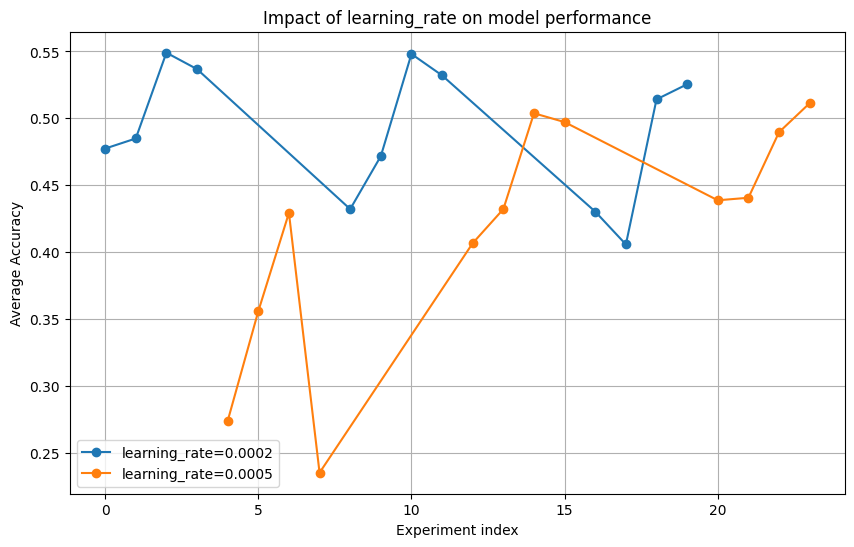

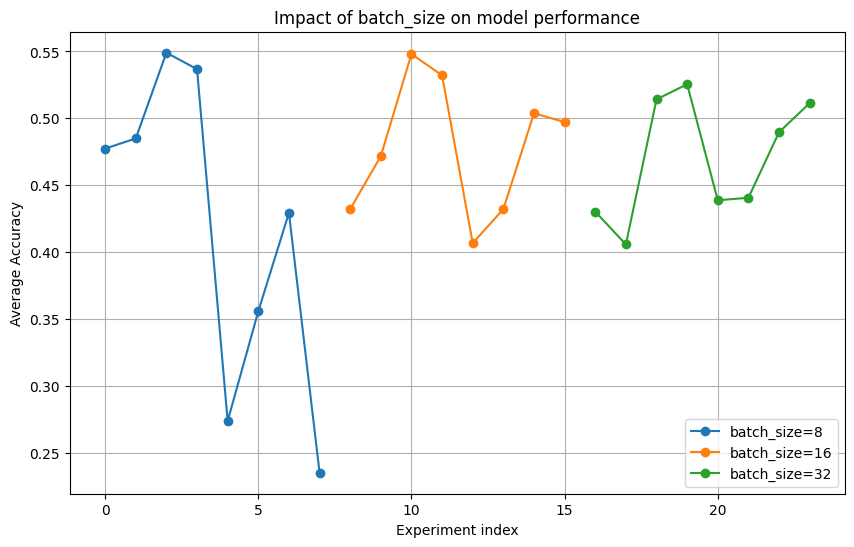

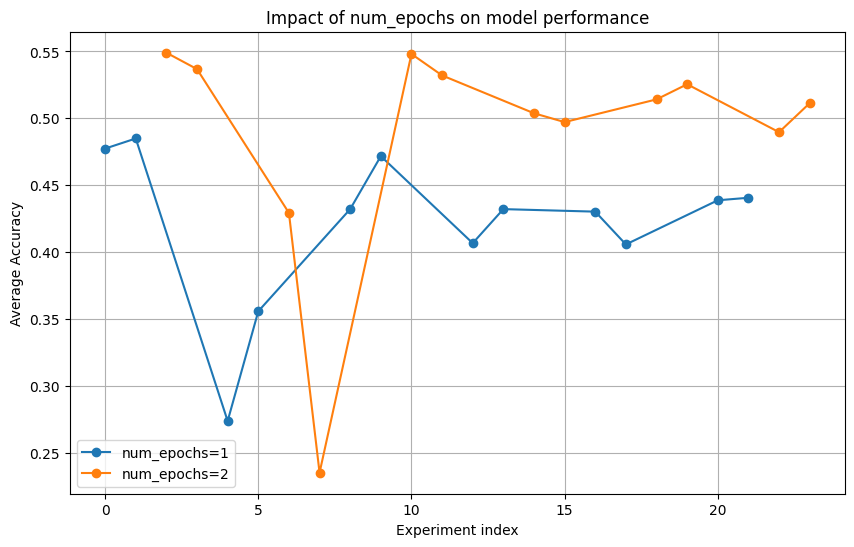

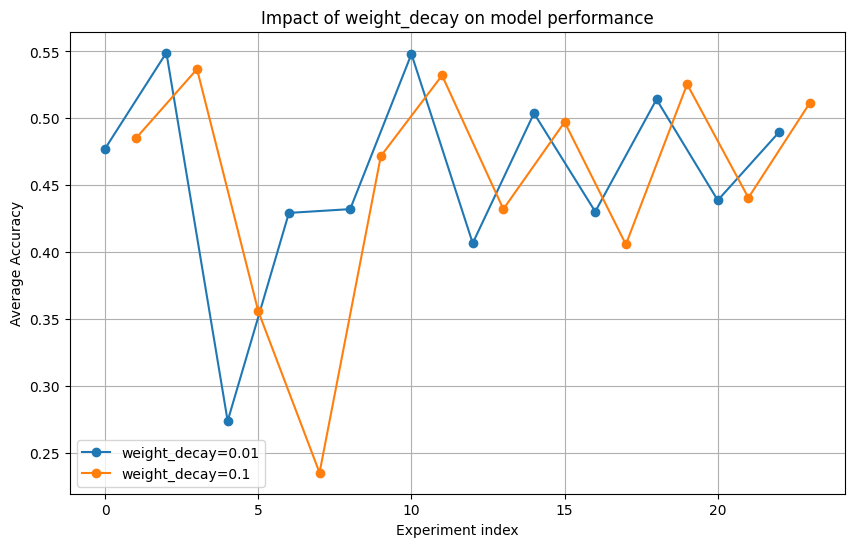

In [124]:
# Visualize the results
import matplotlib.pyplot as plt
import pandas as pd

# Extract results into a DataFrame
df_results = pd.DataFrame([
    {
        'learning_rate': r['params']['learning_rate'],
        'batch_size': r['params']['batch_size'],
        'num_epochs': r['params']['num_epochs'],
        'weight_decay': r['params']['weight_decay'],
        'genre_accuracy': r['eval_results'].get('eval_genre_accuracy', 0),
        'style_accuracy': r['eval_results'].get('eval_style_accuracy', 0),
        'avg_accuracy': r['eval_results'].get('eval_avg_accuracy', 0)
    }
    for r in results
])

# Plot the results
plt.figure(figsize=(12, 8))
for param in param_grid.keys():
    plt.figure(figsize=(10, 6))
    for value in param_grid[param]:
        subset = df_results[df_results[param] == value]
        plt.plot(subset.index, subset['avg_accuracy'], 'o-', label=f"{param}={value}")

    plt.xlabel('Experiment index')
    plt.ylabel('Average Accuracy')
    plt.title(f'Impact of {param} on model performance')
    plt.legend()
    plt.grid(True)
    plt.show()


In [125]:
best_model = ViTMultiTask(num_genres=len(genres), num_styles=len(styles))
best_model.to(device)

best_train_args = TrainingArguments(
    output_dir="output-models/best-model",
    per_device_train_batch_size=best_params['batch_size'],
    num_train_epochs=best_params['num_epochs'],
    fp16=True,
    save_steps=10,
    eval_steps=10,
    logging_steps=10,
    learning_rate=best_params['learning_rate'],
    weight_decay=best_params['weight_decay'],
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
    eval_strategy='steps',
    metric_for_best_model='eval_avg_accuracy',
)

best_trainer = MultiTaskTrainer(
    model=best_model,
    args=best_train_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

print("Training final model with best hyperparameters...")
best_trainer.train()

# Save the best model
torch.save(best_model.state_dict(), "models/best_model.pt")
print("Best model saved!")

# Evaluate the best model
best_eval_results = best_trainer.evaluate()
print("Final evaluation results:")
print(best_eval_results)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training final model with best hyperparameters...


Best model saved!


Final evaluation results:
{'eval_genre_accuracy': 0.6490566037735849, 'eval_style_accuracy': 0.4547169811320755, 'eval_avg_accuracy': 0.5518867924528301, 'eval_loss': 2.7873079776763916, 'eval_runtime': 53.1481, 'eval_samples_per_second': 9.972, 'eval_steps_per_second': 1.261, 'epoch': 2.0}


#### Save model

In [127]:
trainer = best_trainer
model = best_model

In [128]:
original_size = os.path.getsize("models/best_model.pt") / 1e6

In [129]:
print(f"Original model size: {original_size:.2f} MB")

Original model size: 345.76 MB


#### Evaluation

In [131]:
import time

start_time = time.time()
outputs = trainer.predict(eval_dataset)
end_time = time.time()

inference_time_original_model = end_time - start_time
print(f"Inference time for original model: {inference_time_original_model:.2f} seconds")
print(outputs.metrics)


Inference time for original model: 65.40 seconds
{'test_loss': 2.7873079776763916, 'test_eval_genre_accuracy': 0.6490566037735849, 'test_eval_style_accuracy': 0.4547169811320755, 'test_eval_avg_accuracy': 0.5518867924528301, 'test_runtime': 65.3994, 'test_samples_per_second': 8.104, 'test_steps_per_second': 1.024}


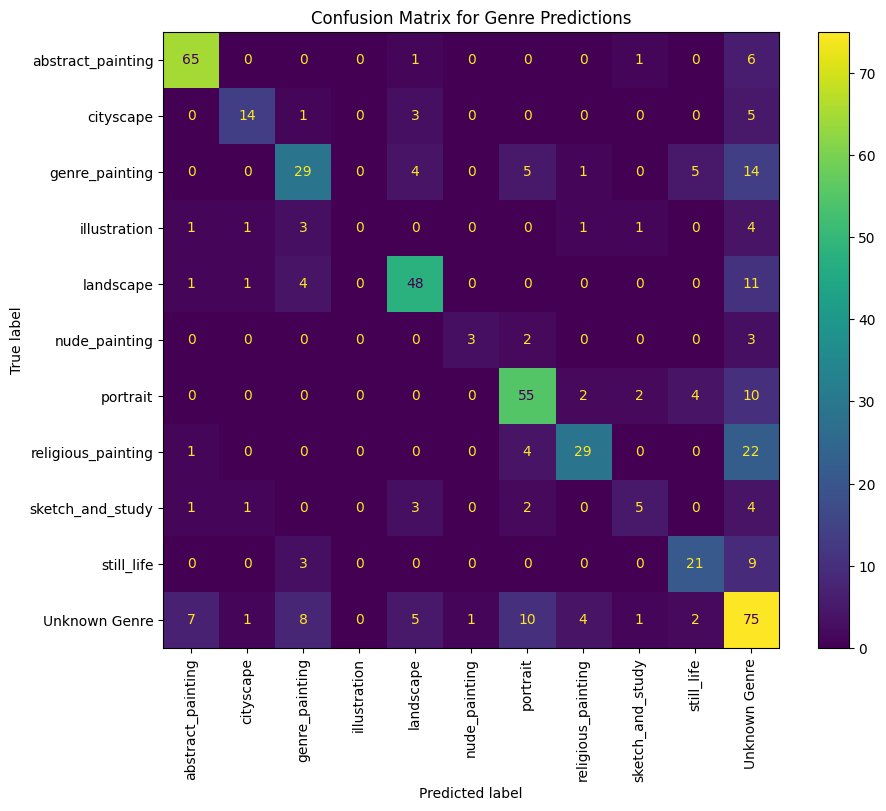

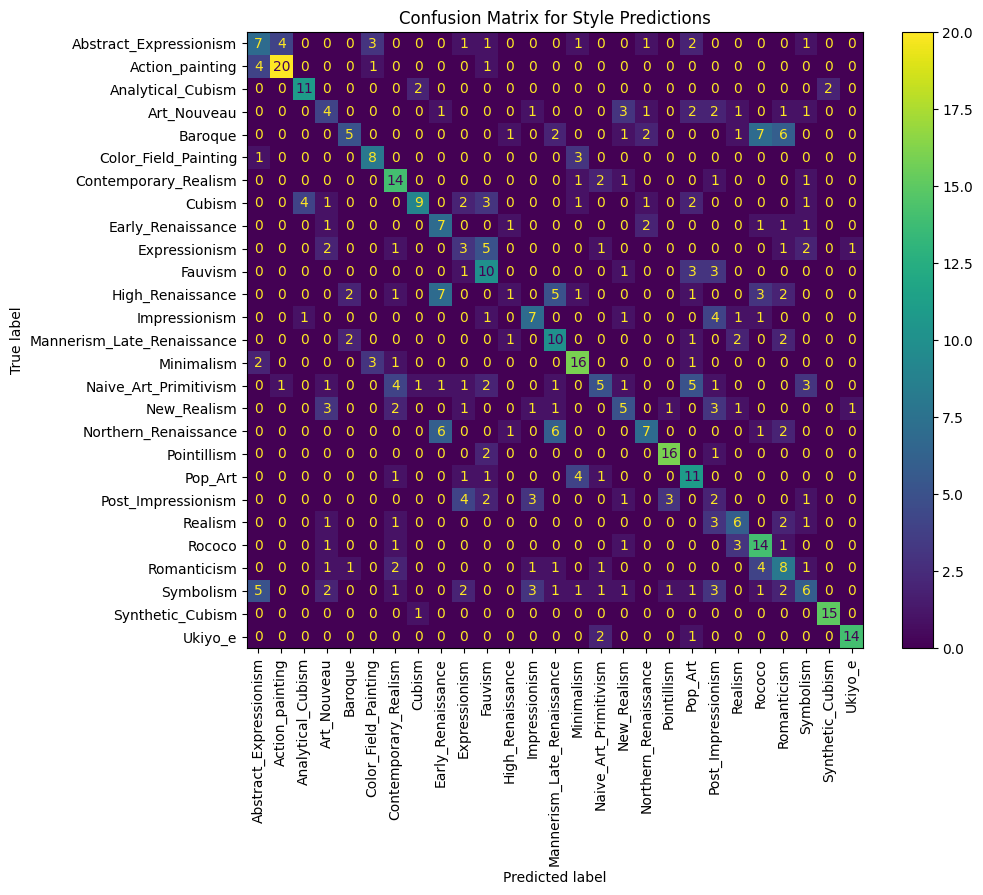

In [132]:
# Extract predictions and true labels for genres and styles
genre_logits, style_logits = outputs.predictions
genre_preds = np.argmax(genre_logits, axis=1)
style_preds = np.argmax(style_logits, axis=1)

genre_labels = outputs.label_ids["genre_labels"]
style_labels = outputs.label_ids["style_labels"]

# Compute confusion matrices
genre_cm = confusion_matrix(genre_labels, genre_preds)
style_cm = confusion_matrix(style_labels, style_preds)

# Display confusion matrix for genres
plt.figure(figsize=(10, 8))
genre_disp = ConfusionMatrixDisplay(confusion_matrix=genre_cm, display_labels=id2genre.values())
genre_disp.plot(xticks_rotation=90, cmap="viridis", ax=plt.gca())
plt.title("Confusion Matrix for Genre Predictions")
plt.show()

# Display confusion matrix for styles
plt.figure(figsize=(10, 8))
style_disp = ConfusionMatrixDisplay(confusion_matrix=style_cm, display_labels=id2style.values())
style_disp.plot(xticks_rotation=90, cmap="viridis", ax=plt.gca())
plt.title("Confusion Matrix for Style Predictions")
plt.show()

In [133]:
print(classification_report(genre_labels, genre_preds, target_names=dataset.features["genre"].names))

                    precision    recall  f1-score   support

 abstract_painting       0.86      0.89      0.87        73
         cityscape       0.78      0.61      0.68        23
    genre_painting       0.60      0.50      0.55        58
      illustration       0.00      0.00      0.00        11
         landscape       0.75      0.74      0.74        65
     nude_painting       0.75      0.38      0.50         8
          portrait       0.71      0.75      0.73        73
religious_painting       0.78      0.52      0.62        56
  sketch_and_study       0.50      0.31      0.38        16
        still_life       0.66      0.64      0.65        33
     Unknown Genre       0.46      0.66      0.54       114

          accuracy                           0.65       530
         macro avg       0.62      0.54      0.57       530
      weighted avg       0.66      0.65      0.64       530



C:\python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [134]:
print(classification_report(style_labels, style_preds, target_names=dataset.features["style"].names))

                            precision    recall  f1-score   support

    Abstract_Expressionism       0.37      0.33      0.35        21
           Action_painting       0.80      0.77      0.78        26
         Analytical_Cubism       0.69      0.73      0.71        15
               Art_Nouveau       0.24      0.24      0.24        17
                   Baroque       0.50      0.20      0.29        25
      Color_Field_Painting       0.53      0.67      0.59        12
      Contemporary_Realism       0.48      0.70      0.57        20
                    Cubism       0.69      0.38      0.49        24
         Early_Renaissance       0.32      0.50      0.39        14
             Expressionism       0.19      0.19      0.19        16
                   Fauvism       0.36      0.56      0.43        18
          High_Renaissance       0.20      0.04      0.07        23
             Impressionism       0.44      0.44      0.44        16
Mannerism_Late_Renaissance       0.37      0.56

### Quantization dynamic

In [154]:
# model_v2 = model

model_v2 = ViTMultiTask(num_genres=len(genres), num_styles=len(styles))
model_v2.load_state_dict(torch.load("models/best_model.pt"))

model_v2.eval()

quantized_model = torch.quantization.quantize_dynamic(
    model_v2, 
    {torch.nn.Linear},
    dtype=torch.qint8
)

#int8 is an integer type, it can be used for any operation which needs integers
# qint8 is a quantized tensor type which represents a compressed floating point tensor, it has an underlying int8 data layer, a scale, a zero_point and a qscheme

# Quantization works only on CPU
quantized_model.to("cpu")

torch.save(quantized_model.state_dict(), "models/quantized_model.pt")
quantized_size = os.path.getsize("models/quantized_model.pt") / 1e6  # w MB

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [155]:
print(f"Original model size: {original_size:.2f} MB")
print(f"Quantized model size: {quantized_size:.2f} MB")

Original model size: 345.76 MB
Quantized model size: 89.15 MB


In [156]:
quantized_model.eval()
quantized_model.to("cpu")

eval_dataloader = DataLoader(eval_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

all_genre_preds = []
all_style_preds = []
all_genre_labels = []
all_style_labels = []

start_time = time.time()
with torch.no_grad():
    for batch in eval_dataloader:
        pixel_values = batch["pixel_values"].to("cpu")
        genre_labels = batch["genre_labels"].to("cpu")
        style_labels = batch["style_labels"].to("cpu")

        genre_logits, style_logits = quantized_model(pixel_values)

        genre_preds = torch.argmax(genre_logits, dim=1)
        style_preds = torch.argmax(style_logits, dim=1)

        all_genre_preds.append(genre_preds.numpy())
        all_style_preds.append(style_preds.numpy())
        all_genre_labels.append(genre_labels.numpy())
        all_style_labels.append(style_labels.numpy())

end_time = time.time()

inference_time_quantized_model = end_time - start_time
print(f"Inference time for quantized model: {inference_time_quantized_model:.2f} seconds")

genre_preds = np.concatenate(all_genre_preds)
style_preds = np.concatenate(all_style_preds)
genre_labels = np.concatenate(all_genre_labels)
style_labels = np.concatenate(all_style_labels)


Inference time for quantized model: 83.82 seconds


In [157]:
print(f"Inference time for original model: {inference_time_original_model:.2f} seconds")
print(f"Inference time for quantized model: {inference_time_quantized_model:.2f} seconds") 

Inference time for original model: 65.40 seconds
Inference time for quantized model: 83.82 seconds


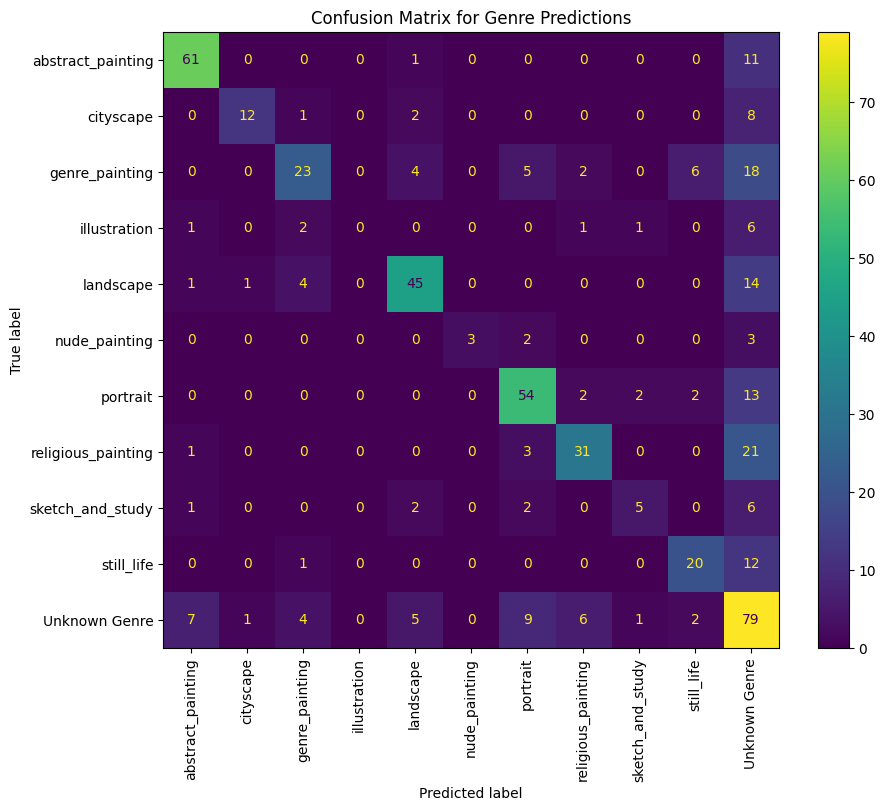

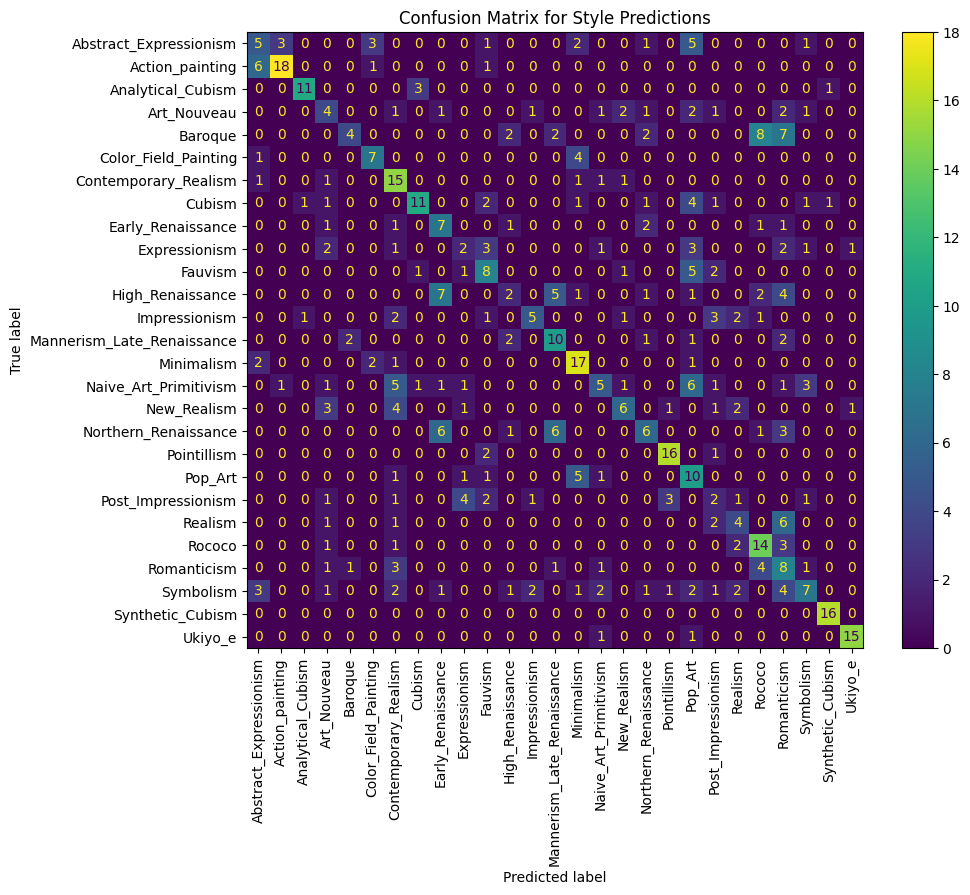

In [158]:
genre_cm = confusion_matrix(genre_labels, genre_preds)
style_cm = confusion_matrix(style_labels, style_preds)

plt.figure(figsize=(10, 8))
genre_disp = ConfusionMatrixDisplay(confusion_matrix=genre_cm, display_labels=id2genre.values())
genre_disp.plot(xticks_rotation=90, cmap="viridis", ax=plt.gca())
plt.title("Confusion Matrix for Genre Predictions")
plt.show()

plt.figure(figsize=(10, 8))
style_disp = ConfusionMatrixDisplay(confusion_matrix=style_cm, display_labels=id2style.values())
style_disp.plot(xticks_rotation=90, cmap="viridis", ax=plt.gca())
plt.title("Confusion Matrix for Style Predictions")
plt.show()

In [159]:
print(classification_report(genre_labels, genre_preds, target_names=dataset.features["genre"].names))

                    precision    recall  f1-score   support

 abstract_painting       0.85      0.84      0.84        73
         cityscape       0.86      0.52      0.65        23
    genre_painting       0.66      0.40      0.49        58
      illustration       0.00      0.00      0.00        11
         landscape       0.76      0.69      0.73        65
     nude_painting       1.00      0.38      0.55         8
          portrait       0.72      0.74      0.73        73
religious_painting       0.74      0.55      0.63        56
  sketch_and_study       0.56      0.31      0.40        16
        still_life       0.67      0.61      0.63        33
     Unknown Genre       0.41      0.69      0.52       114

          accuracy                           0.63       530
         macro avg       0.66      0.52      0.56       530
      weighted avg       0.66      0.63      0.63       530



C:\python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [160]:
print(classification_report(style_labels, style_preds, target_names=dataset.features["style"].names))

                            precision    recall  f1-score   support

    Abstract_Expressionism       0.28      0.24      0.26        21
           Action_painting       0.82      0.69      0.75        26
         Analytical_Cubism       0.85      0.73      0.79        15
               Art_Nouveau       0.22      0.24      0.23        17
                   Baroque       0.57      0.16      0.25        25
      Color_Field_Painting       0.54      0.58      0.56        12
      Contemporary_Realism       0.38      0.75      0.51        20
                    Cubism       0.69      0.46      0.55        24
         Early_Renaissance       0.30      0.50      0.38        14
             Expressionism       0.20      0.12      0.15        16
                   Fauvism       0.38      0.44      0.41        18
          High_Renaissance       0.22      0.09      0.12        23
             Impressionism       0.56      0.31      0.40        16
Mannerism_Late_Renaissance       0.42      0.56

### Quantization static

In [161]:
from torch.utils.data import Subset

subset_size = int(0.1 * len(train_dataset))
calibration_subset = Subset(train_dataset, list(range(subset_size)))

calibration_loader = DataLoader(
    calibration_subset, batch_size=16, shuffle=False, collate_fn=collate_fn
)

model_v3 = ViTMultiTask(num_genres=len(genres), num_styles=len(styles))
model_v3.load_state_dict(torch.load("models/best_model.pt"))

model_v3.eval()

model_v3.qconfig = torch.quantization.get_default_qconfig('fbgemm')
# fbgemm - backend kwantyzacji
# torch.qint8 – dla wag (signed int8)
# torch.quint8 – dla aktywacji (unsigned int8)

torch.quantization.prepare(model_v3, inplace=True)
# Kalibracja
with torch.no_grad():
    for batch in calibration_loader:
        pixel_values = batch["pixel_values"]
        model_v3(pixel_values)
torch.quantization.convert(model_v3, inplace=True)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\python\Lib\site-packages\torch\ao\quantization\observer.py:244: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


ViTMultiTask(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): QuantizedConv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), scale=0.12384171038866043, zero_point=64)
      )
      (dropout): QuantizedDropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): QuantizedLinear(in_features=768, out_features=768, scale=0.1522662490606308, zero_point=63, qscheme=torch.per_channel_affine)
              (key): QuantizedLinear(in_features=768, out_features=768, scale=0.13507333397865295, zero_point=64, qscheme=torch.per_channel_affine)
              (value): QuantizedLinear(in_features=768, out_features=768, scale=0.051693957298994064, zero_point=65, qscheme=torch.per_channel_affine)
            )
            (output): ViTSelfOutput(
              (dense): QuantizedLin

In [162]:
# Quantization works only on CPU
model_v3.to("cpu")

torch.save(model_v3.state_dict(), "models/static_quantized_model.pt")
static_quantized_size = os.path.getsize("models/static_quantized_model.pt") / 1e6  # w MB

In [163]:
print(f"Original model size: {original_size:.2f} MB")
print(f"Quantized model size: {quantized_size:.2f} MB")
print(f"Quantized model qint4 size: {static_quantized_size:.2f} MB")

Original model size: 345.76 MB
Quantized model size: 89.15 MB
Quantized model qint4 size: 88.80 MB


In [164]:
quantized_model.eval()
quantized_model.to("cpu")

eval_dataloader = DataLoader(eval_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

all_genre_preds = []
all_style_preds = []
all_genre_labels = []
all_style_labels = []

start_time = time.time()
with torch.no_grad():
    for batch in eval_dataloader:
        pixel_values = batch["pixel_values"].to("cpu")
        genre_labels = batch["genre_labels"].to("cpu")
        style_labels = batch["style_labels"].to("cpu")

        genre_logits, style_logits = quantized_model(pixel_values)

        genre_preds = torch.argmax(genre_logits, dim=1)
        style_preds = torch.argmax(style_logits, dim=1)

        all_genre_preds.append(genre_preds.numpy())
        all_style_preds.append(style_preds.numpy())
        all_genre_labels.append(genre_labels.numpy())
        all_style_labels.append(style_labels.numpy())

end_time = time.time()

inference_time_static_quantized_model = end_time - start_time
print(f"Inference time for static quantized model: {inference_time_static_quantized_model:.2f} seconds")

genre_preds = np.concatenate(all_genre_preds)
style_preds = np.concatenate(all_style_preds)
genre_labels = np.concatenate(all_genre_labels)
style_labels = np.concatenate(all_style_labels)


Inference time for static quantized model: 76.22 seconds


In [165]:
print(f"Inference time for original model: {inference_time_original_model:.2f} seconds")
print(f"Inference time for quantized model: {inference_time_quantized_model:.2f} seconds") 
print(f"Inference time for static quantized model: {inference_time_static_quantized_model:.2f} seconds")

Inference time for original model: 65.40 seconds
Inference time for quantized model: 83.82 seconds
Inference time for static quantized model: 76.22 seconds


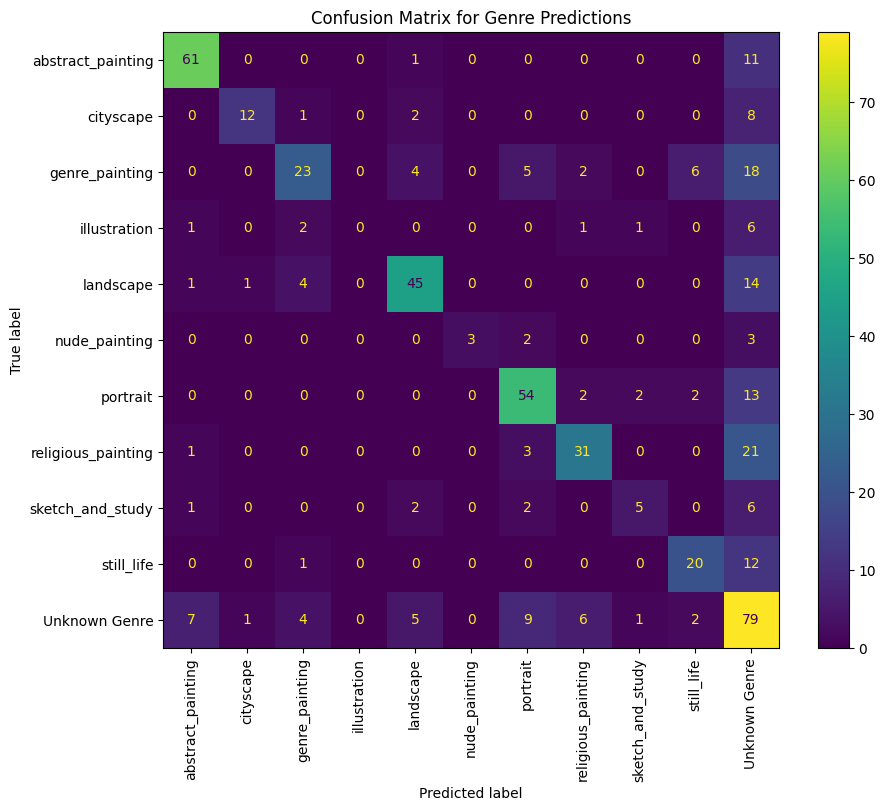

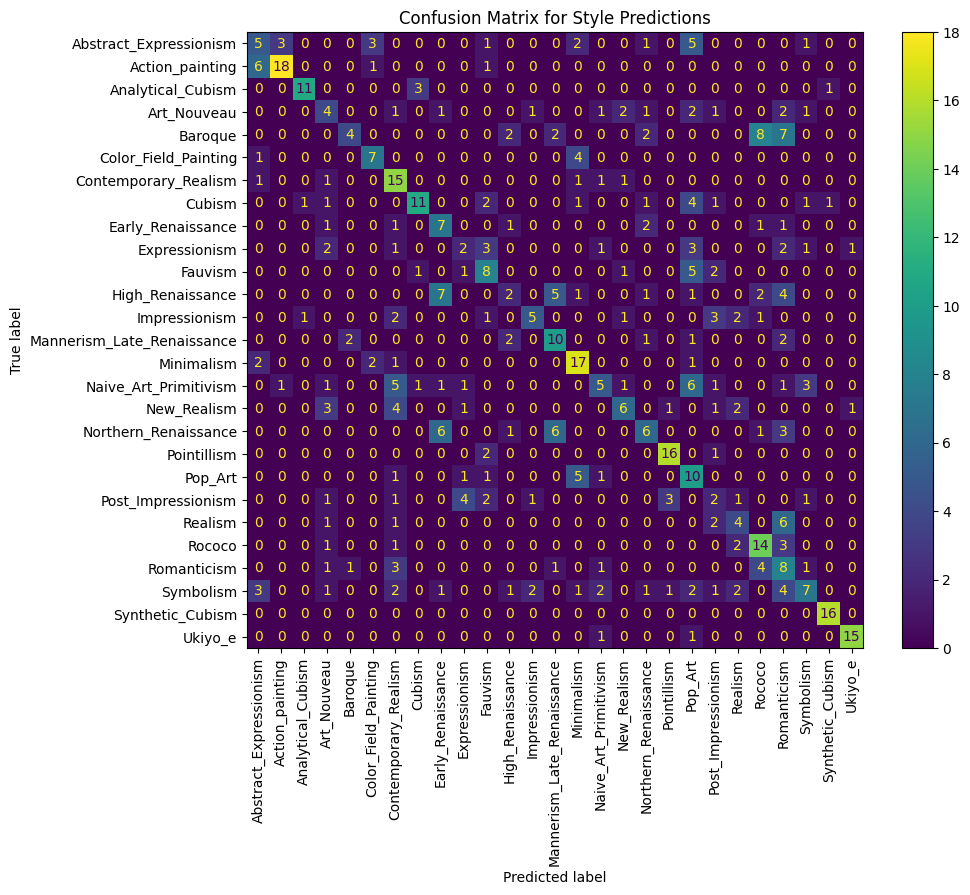

In [166]:
genre_cm = confusion_matrix(genre_labels, genre_preds)
style_cm = confusion_matrix(style_labels, style_preds)

plt.figure(figsize=(10, 8))
genre_disp = ConfusionMatrixDisplay(confusion_matrix=genre_cm, display_labels=id2genre.values())
genre_disp.plot(xticks_rotation=90, cmap="viridis", ax=plt.gca())
plt.title("Confusion Matrix for Genre Predictions")
plt.show()

plt.figure(figsize=(10, 8))
style_disp = ConfusionMatrixDisplay(confusion_matrix=style_cm, display_labels=id2style.values())
style_disp.plot(xticks_rotation=90, cmap="viridis", ax=plt.gca())
plt.title("Confusion Matrix for Style Predictions")
plt.show()

In [167]:
print(classification_report(genre_labels, genre_preds, target_names=dataset.features["genre"].names))

                    precision    recall  f1-score   support

 abstract_painting       0.85      0.84      0.84        73
         cityscape       0.86      0.52      0.65        23
    genre_painting       0.66      0.40      0.49        58
      illustration       0.00      0.00      0.00        11
         landscape       0.76      0.69      0.73        65
     nude_painting       1.00      0.38      0.55         8
          portrait       0.72      0.74      0.73        73
religious_painting       0.74      0.55      0.63        56
  sketch_and_study       0.56      0.31      0.40        16
        still_life       0.67      0.61      0.63        33
     Unknown Genre       0.41      0.69      0.52       114

          accuracy                           0.63       530
         macro avg       0.66      0.52      0.56       530
      weighted avg       0.66      0.63      0.63       530



C:\python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [168]:
print(classification_report(style_labels, style_preds, target_names=dataset.features["style"].names))

                            precision    recall  f1-score   support

    Abstract_Expressionism       0.28      0.24      0.26        21
           Action_painting       0.82      0.69      0.75        26
         Analytical_Cubism       0.85      0.73      0.79        15
               Art_Nouveau       0.22      0.24      0.23        17
                   Baroque       0.57      0.16      0.25        25
      Color_Field_Painting       0.54      0.58      0.56        12
      Contemporary_Realism       0.38      0.75      0.51        20
                    Cubism       0.69      0.46      0.55        24
         Early_Renaissance       0.30      0.50      0.38        14
             Expressionism       0.20      0.12      0.15        16
                   Fauvism       0.38      0.44      0.41        18
          High_Renaissance       0.22      0.09      0.12        23
             Impressionism       0.56      0.31      0.40        16
Mannerism_Late_Renaissance       0.42      0.56

# Original model on cpu

In [169]:
model_cpu = ViTMultiTask(num_genres=len(genres), num_styles=len(styles))
model_cpu.load_state_dict(torch.load("models/best_model.pt"))
model_cpu.to("cpu")

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTMultiTask(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn):

In [170]:
model_cpu.eval()
model_cpu.to("cpu")

eval_dataloader = DataLoader(eval_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

all_genre_preds = []
all_style_preds = []
all_genre_labels = []
all_style_labels = []

start_time = time.time()
with torch.no_grad():
    for batch in eval_dataloader:
        pixel_values = batch["pixel_values"].to("cpu")
        genre_labels = batch["genre_labels"].to("cpu")
        style_labels = batch["style_labels"].to("cpu")

        genre_logits, style_logits = model_cpu(pixel_values)

        genre_preds = torch.argmax(genre_logits, dim=1)
        style_preds = torch.argmax(style_logits, dim=1)

        all_genre_preds.append(genre_preds.numpy())
        all_style_preds.append(style_preds.numpy())
        all_genre_labels.append(genre_labels.numpy())
        all_style_labels.append(style_labels.numpy())

end_time = time.time()

inference_time_model_cpu = end_time - start_time
print(f"Inference time for original model cpu: {inference_time_model_cpu:.2f} seconds")

genre_preds = np.concatenate(all_genre_preds)
style_preds = np.concatenate(all_style_preds)
genre_labels = np.concatenate(all_genre_labels)
style_labels = np.concatenate(all_style_labels)


Inference time for original model cpu: 99.63 seconds


In [171]:
print(f"Inference time for original model cuda: {inference_time_original_model:.2f} seconds")
print(f"Inference time for dynamic quantized model: {inference_time_quantized_model:.2f} seconds")
print(f"Inference time for static quantized model: {inference_time_static_quantized_model:.2f} seconds")
print(f"Inference time for original model cpu: {inference_time_model_cpu:.2f} seconds")

Inference time for original model cuda: 65.40 seconds
Inference time for dynamic quantized model: 83.82 seconds
Inference time for static quantized model: 76.22 seconds
Inference time for original model cpu: 99.63 seconds


In [172]:
print(f"Original model size: {original_size:.2f} MB")
print(f"Dynamic quantized model size: {quantized_size:.2f} MB")
print(f"Static quantized model size: {static_quantized_size:.2f} MB")

Original model size: 345.76 MB
Dynamic quantized model size: 89.15 MB
Static quantized model size: 88.80 MB
